In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
train = pd.read_csv("split/train.csv")
dev = pd.read_csv("split/dev.csv")
test = pd.read_csv("split/test.csv")

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
TEXT = "aliased_snippet"
RESULT = "is_parent"
COMPANY1= "company1"
COMPANY2 = "company2"

In [7]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT])
corpus.shape

(79383,)

In [9]:
num_words = 50000
max_len = 50

In [13]:
tokenizer  = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(corpus)

In [24]:
def tokenize(data):
    tokenized = tokenizer.texts_to_sequences(data[TEXT])
    tokenized = pad_sequences(tokenized,maxlen=max_len)
    return tokenized

In [25]:
train_tokenized = tokenize(train)

In [28]:
train_tokenized.shape, train_tokenized[0]

((55568, 50),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  136,   23,    2,
        1138,   19,    3,  107,  100,  955,  136,   23,    2, 1138,   19,
           3,  107,  100,  955,    2,    4], dtype=int32))

In [69]:
dev_tokenized = tokenize(dev)

In [70]:
dev_tokenized.shape

(15876, 50)

In [40]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, Bidirectional, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
model = Sequential([
    Embedding(num_words,128, input_length=train_tokenized.shape[1]),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 128)           6400000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           98816     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 6,515,457
Trainable params: 6,515,457
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [72]:
early_stoping = EarlyStopping(patience=2)


In [73]:
checkpoint = ModelCheckpoint(filepath="./models/bi_lstm.h5")
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=256, epochs=5, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/5
55568/55568 [==============================] - 20s 367us/step - loss: 0.1418 - acc: 0.9515 - val_loss: 0.3823 - val_acc: 0.8628
Epoch 2/5
55568/55568 [==============================] - 20s 356us/step - loss: 0.0793 - acc: 0.9726 - val_loss: 0.4342 - val_acc: 0.8610
Epoch 3/5
55568/55568 [==============================] - 20s 354us/step - loss: 0.0548 - acc: 0.9809 - val_loss: 0.4900 - val_acc: 0.8621


In [76]:
test = pd.read_csv("split/test.csv")

In [78]:
test_tokenized = tokenize(test)
test_tokenized.shape

(7939, 50)

In [79]:
predictions = model.predict(test_tokenized)

In [88]:
predictions[:5]

array([[4.3058610e-01],
       [3.8495375e-04],
       [2.0379677e-01],
       [9.9996352e-01],
       [2.5654031e-04]], dtype=float32)

In [89]:
predictions_binary = np.round(predictions)
predictions_binary[:5]

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

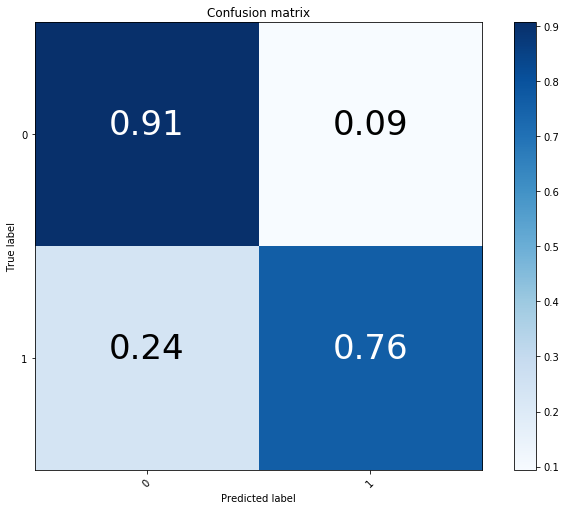

In [91]:
plot_confusion_matrix(test[RESULT], predictions_binary,classes=[0,1], normalize=True)

In [92]:
from sklearn.metrics import f1_score

In [93]:
f1_score(test[RESULT], predictions_binary)

0.7687379884689302

In [ ]:
from sklearn.metrics